Olman Alexander Silva
2343025

Desarrollo guia 4 y 5 con nuevo dataset CIFAR-10 proyecto FACN

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import helper

Obtencion del dataset

In [3]:
# 1. Definir transformación para imágenes a color (3 canales)
# Normalize recibe ((mean_R, mean_G, mean_B), (std_R, std_G, std_B))
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 2. Descargar y cargar datos de entrenamiento (CIFAR-10)
trainset = datasets.CIFAR10('CIFAR_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# 3. Descargar y cargar datos de prueba (CIFAR-10)
testset = datasets.CIFAR10('CIFAR_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

# Verificación rápida
print("¡CIFAR-10 cargado correctamente!")

100%|██████████| 170M/170M [00:02<00:00, 84.0MB/s]


¡CIFAR-10 cargado correctamente!


Construyendo la red

In [ ]:
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        ''' Builds a feedforward network with arbitrary hidden layers.
        '''
        super().__init__()
        # Add the first layer, input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])

        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])

        self.output = nn.Linear(hidden_layers[-1], output_size)

        self.dropout = nn.Dropout(p=drop_p)

    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''

        # Forward through each layer in `hidden_layers`, with ReLU activation and dropout
        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            x = self.dropout(x)

        x = self.output(x)

        return F.log_softmax(x, dim=1)

Entrenamiento de la red

In [ ]:
# Create the network, define the criterion and optimizer
model = Network(3072, 10, [516, 256], drop_p=0.5)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Funcion de Validacion

In [ ]:
# Implement a function for the validation pass
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:

        images.resize_(images.shape[0], 3072)

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()

    return test_loss, accuracy

Entrenamiento

In [ ]:
epochs = 2
steps = 0
running_loss = 0
print_every = 40
for e in range(epochs):
    model.train()
    for images, labels in trainloader:
        steps += 1

        # Flatten images into a 784 long vector
        images.resize_(images.size()[0], 3072)

        optimizer.zero_grad()

        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            # Make sure network is in eval mode for inference
            model.eval()

            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                test_loss, accuracy = validation(model, testloader, criterion)

            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

            running_loss = 0

            # Make sure training is back on
            model.train()

Epoch: 1/2..  Training Loss: 2.175..  Test Loss: 1.922..  Test Accuracy: 0.323
Epoch: 1/2..  Training Loss: 2.006..  Test Loss: 1.838..  Test Accuracy: 0.355
Epoch: 1/2..  Training Loss: 1.917..  Test Loss: 1.787..  Test Accuracy: 0.366
Epoch: 1/2..  Training Loss: 1.924..  Test Loss: 1.780..  Test Accuracy: 0.374
Epoch: 1/2..  Training Loss: 1.889..  Test Loss: 1.753..  Test Accuracy: 0.382
Epoch: 1/2..  Training Loss: 1.885..  Test Loss: 1.749..  Test Accuracy: 0.379
Epoch: 1/2..  Training Loss: 1.842..  Test Loss: 1.721..  Test Accuracy: 0.389
Epoch: 1/2..  Training Loss: 1.886..  Test Loss: 1.732..  Test Accuracy: 0.397
Epoch: 1/2..  Training Loss: 1.845..  Test Loss: 1.701..  Test Accuracy: 0.404
Epoch: 1/2..  Training Loss: 1.805..  Test Loss: 1.714..  Test Accuracy: 0.404
Epoch: 1/2..  Training Loss: 1.838..  Test Loss: 1.682..  Test Accuracy: 0.411
Epoch: 1/2..  Training Loss: 1.789..  Test Loss: 1.681..  Test Accuracy: 0.414
Epoch: 1/2..  Training Loss: 1.798..  Test Loss: 1.6

Funcion para ver las imagenes

In [ ]:
def view_classify(img, ps, version="MNIST"):
    ''' Función para ver una imagen y sus clases predichas. '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    img = img.permute(1, 2, 0)
    img = img / 2 + 0.5
    img = np.clip(img, 0, 1) # Aseguramos que los valores estén entre 0 y 1

    ax1.imshow(img.numpy())
    ax1.axis('off')

    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))

    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                            'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot'], size='small')
    elif version == "CIFAR":
        ax2.set_yticklabels(['Avión', 'Auto', 'Pájaro', 'Gato', 'Venado',
                            'Perro', 'Rana', 'Caballo', 'Barco', 'Camión'], size='small')

    ax2.set_title('Probabilidad de Clase')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

Inferencia

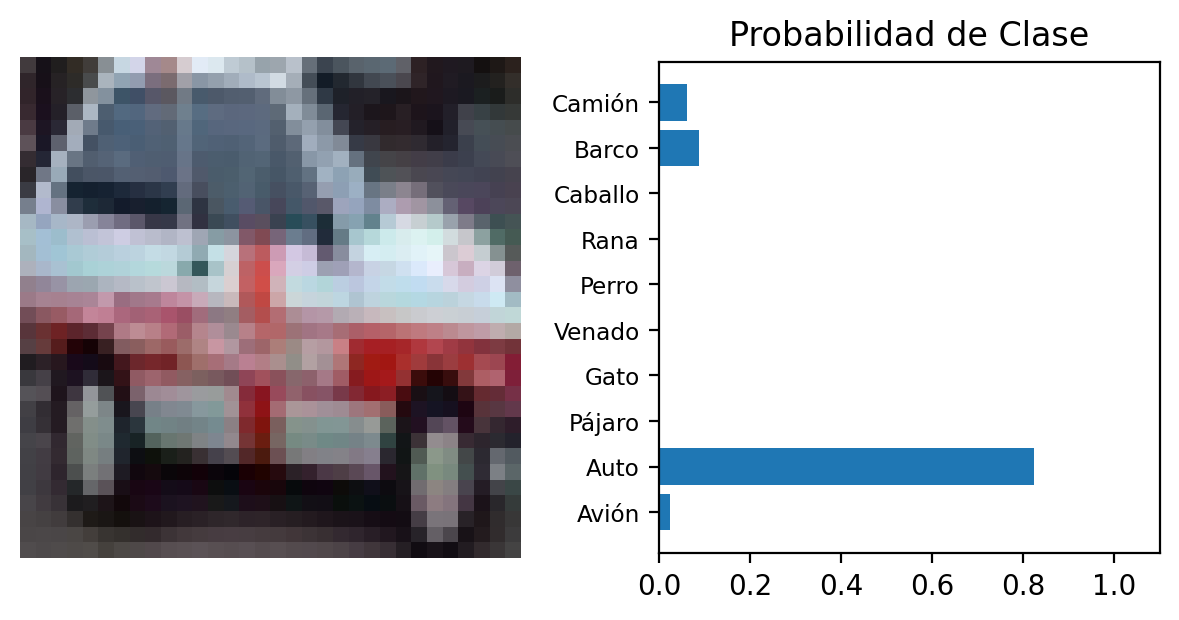

In [ ]:
# Test out your network!
model.eval()

dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[0]

# 1. Aplanar la imagen para la red (Input layer: 3072)
img_flatten = img.view(1, 3072)

# 2. Calcular probabilidades
with torch.no_grad():
    output = model.forward(img_flatten)

ps = torch.exp(output)

# 3. Visualizar
# Pasamos la imagen original 'img' (3, 32, 32) a la función, no la aplanada
view_classify(img, ps, version='CIFAR')